# Phenotype classifcation using CellX 

This notebook shows how to take segmented time lapse microscopy images and use h2b fluorescence markers to classfiy mitotic state of the cell cycle. 

The sections of this notebook are as follows:

1. Load images
2. something
3. something else
4. Class

The data used in this notebook is timelapse microscopy data with h2b-gfp/rfp markers that show the spatial extent of the nucleus and it's mitotic state. 

This notebook uses the dask octopuslite image loader from the CellX/Lowe lab project.

In [87]:
from octopuslite import DaskOctopusLiteLoader
import btrack
from tqdm import tqdm
import numpy as np
from scipy.special import softmax
import os
import matplotlib.pyplot as plt
from skimage.io import imread, imshow

## 1. Load segmentation images - dask is inverting the background???

In [38]:
# load images
expt = 'MK0003'
pos = 'Pos15'
image_path = f'/home/nathan/data/kraken/test/{expt}/{pos}/{pos}_stardist_masks'
### dask octo loader seems to invert the background
images = DaskOctopusLiteLoader(image_path)#, crop=(1200,1600), remove_background=False,)

Using cropping: None


Using cropping: (1200, 1600)


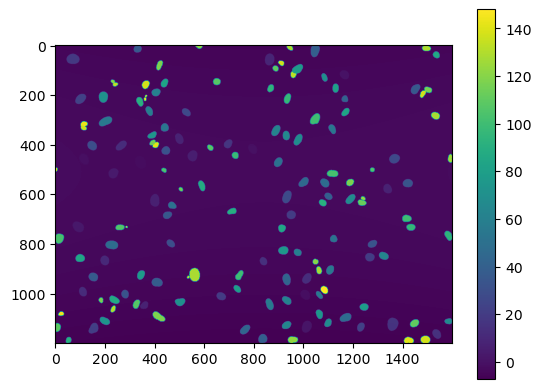

In [50]:
images = DaskOctopusLiteLoader(image_path, crop=(1200,1600), remove_background=False,)
plt.imshow(images['mask'][0])
plt.colorbar()
plt.show()

In [53]:
images['mask'][0].compute()

array([[-4.901371 , -4.902881 , -4.90439  , ..., -5.0351524, -5.0338087,
        -5.0324616],
       [-4.8932776, -4.894788 , -4.8962965, ..., -5.0270576, -5.025714 ,
        -5.024367 ],
       [-4.8852005, -4.8867106, -4.8882194, ..., -5.018979 , -5.017635 ,
        -5.0162883],
       ...,
       [-6.5685835, -6.5700927, -6.5716004, ..., -6.700725 , -6.6993804,
        -6.698032 ],
       [-6.5794773, -6.5809865, -6.5824943, ..., -6.7116175, -6.710273 ,
        -6.7089243],
       [-6.5903883, -6.5918975, -6.5934052, ..., -6.722527 , -6.7211823,
        -6.7198343]], dtype=float32)

In [62]:
import glob
stack = []
for fn in glob.glob(image_path+'/*.tif'):
    image = imread(fn)
    stack.append(image) 
segmentation_gfp = np.stack(stack)

## 2. Localise the objects

In [63]:
objects_gfp = btrack.utils.segmentation_to_objects(
    segmentation_gfp,
    properties = ('area', ),
)

[INFO][2021/11/18 12:27:33 pm] Localizing objects from segmentation...
[INFO][2021/11/18 12:27:43 pm] Objects are of type: <class 'dict'>
[INFO][2021/11/18 12:27:44 pm] ...Found 77959 objects in 465 frames.


In [ ]:
objects_rfp = btrack.utils.segmentation_to_objects(
    segmentation_rfp,
    properties = ('area', ),
)

## 3. Classify the objects 

In [67]:
from cellx import load_model
from cellx.tools.image import InfinitePaddedImage
from skimage.transform import resize

model = load_model('/home/nathan/analysis/cell-comp-analysis/segment-classify-track/models/cellx_classifier_stardist.h5')

In [68]:
LABELS = ["interphase", "prometaphase", "metaphase", "anaphase", "apoptosis"]

In [73]:
def normalize_channels(x):
    for dim in range(x.shape[-1]):
        x[..., dim] = normalize(x[..., dim])
    return x￼
1
def normalize_channels(x):
2
    for dim in range(x.shape[-1]):
3
        x[..., dim] = normalize(x[..., dim])
4
    return x
In [ ]:
￼
1
def normalize(x):
2
    xf = x.astsype(np.float32)
3
    mx = np.mean(xf)
4
    sd = np.max([np.std(xf), 1./np.prod(x.shape)])
5
    return (xf - mx) / sd
In [ ]:


In [74]:
def normalize(x):
    xf = x.astype(np.float32)
    mx = np.mean(xf)
    sd = np.max([np.std(xf), 1./np.prod(x.shape)])
    return (xf - mx) / sd

In [75]:
def classify_objects(image, objects, obj_type=1):
    labels = []
    for n in tqdm(range(image.shape[0])):

        _objects = [o for o in objects if o.t == n]

        crops = []
        to_update = []
        
        
        fp = gfp if obj_type == 1 else rfp


        frame = np.stack(
            [image[n, ...].compute(), fp[n, ...].compute()], 
            axis=-1,
        ) 

        vol = InfinitePaddedImage(frame)

        for obj in _objects:
            xs = slice(int(obj.x-40), int(obj.x+40), 1)
            ys = slice(int(obj.y-40), int(obj.y+40), 1)

            crop = vol[ys, xs, :]
            crop = resize(crop, (64, 64), preserve_range=True).astype(np.float32)

            if crop.shape == (64 ,64, 2):
                crops.append(normalize_channels(crop))
                to_update.append(obj)
            else:
                print(crop.shape)

        if not crops:
            continue


        pred = model.predict(np.stack(crops, axis=0))

        assert pred.shape[0] == len(_objects)
        for idx in range(pred.shape[0]):
            obj = _objects[idx]

            pred_label = np.argmax(pred[idx, ...])
            pred_softmax = softmax(pred[idx, ...])

            logits = {f"prob_{k}": pred_softmax[ki] for ki, k in enumerate(LABELS)}

            obj.label = pred_label
            obj.properties = logits
            
    return objects

In [81]:
image = DaskOctopusLiteLoader('/home/nathan/data/kraken/test/MK0003/Pos15/Pos15_raw', crop = (1200,1600))
bf = image['brightfield'][0:len(segmentation_gfp),...]
gfp = image['gfp'][0:len(segmentation_gfp),...]
rfp = image['rfp'][0:len(segmentation_gfp),...]

Using cropping: (1200, 1600)


In [85]:
objects_gfp = classify_objects(bf, objects_gfp, obj_type = 1)

100%|██████████| 465/465 [09:05<00:00,  1.17s/it]


In [89]:
with btrack.dataio.HDF5FileHandler(
    os.path.join('/home/nathan/data/kraken/test/MK0003/Pos15/segmented.h5'), 'w', obj_type='obj_type_1',
) as hdf:
    hdf.write_segmentation(segmentation_gfp.astype(np.uint16))
    hdf.write_objects(objects_gfp)

[INFO][2021/11/18 01:59:56 pm] Opening HDF file: /home/nathan/data/kraken/test/MK0003/Pos15/segmented.h5...
[INFO][2021/11/18 02:00:11 pm] Writing objects/obj_type_1
[INFO][2021/11/18 02:00:11 pm] Writing labels/obj_type_1
[INFO][2021/11/18 02:00:11 pm] Writing properties/obj_type_1
[INFO][2021/11/18 02:00:11 pm] Closing HDF file: /home/nathan/data/kraken/test/MK0003/Pos15/segmented.h5


In [91]:
objects_gfp[0]

,ID,x,y,z,t,dummy,states,label,prob,area,prob_interphase,prob_prometaphase,prob_metaphase,prob_anaphase,prob_apoptosis
0,0,131.197368,477.65311,0.0,0,False,0,0,0.0,1672,0.743234,2.535485e-07,0.000032,0.000016,0.256718


## 4. Filter the objects 

In [92]:
filtered_objects = [o for o in objects_gfp if o.properties['area']>100.]

## 5. Run btrack  

In [96]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file(
        "/home/nathan/analysis/cell-comp-analysis/BayesianTracker/models/MDCK_config_new.json"
    )
    tracker.max_search_radius = 40

    # append the objects to be tracked
    tracker.append(filtered_objects)

    # set the volume
    tracker.volume=((0, 1200), (0, 1600), (-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=100)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    tracker.export(('/home/nathan/data/kraken/test/MK0003/Pos15/tracking.h5'), obj_type='obj_type_1')

    # get the tracks in a format for napari visualization
    data, properties, graph = tracker.to_napari(ndim=2)
    
    tracks = tracker.tracks

[INFO][2021/11/18 03:11:07 pm] Loaded btrack: /home/nathan/src/btrack/btrack/libs/libtracker.so
[INFO][2021/11/18 03:11:07 pm] btrack (v0.4.2) library imported
[INFO][2021/11/18 03:11:07 pm] Setting max XYZ search radius to: 100
[INFO][2021/11/18 03:11:07 pm] Starting BayesianTracker session
[INFO][2021/11/18 03:11:07 pm] Loading configuration file: /home/nathan/analysis/cell-comp-analysis/BayesianTracker/models/MDCK_config_new.json
[INFO][2021/11/18 03:11:07 pm] Loading motion model: b'MDCK_motion_Kristina'
[INFO][2021/11/18 03:11:07 pm] Setting max XYZ search radius to: 40
[INFO][2021/11/18 03:11:07 pm] Objects are of type: <class 'list'>
[INFO][2021/11/18 03:11:07 pm] Set volume to ((0, 1200), (0, 1600), (-100000.0, 100000.0))
[INFO][2021/11/18 03:11:07 pm] Starting tracking... 
[INFO][2021/11/18 03:11:08 pm] Tracking objects in frames 0 to 99 (of 465)...
[INFO][2021/11/18 03:11:09 pm]  - Timing (Bayesian updates: 11.48ms, Linking: 1.00ms)
[INFO][2021/11/18 03:11:09 pm]  - Probabili